<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/bias_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [188]:
import os
import pickle

import gensim.downloader as api
from gensim.matutils import cossim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from matplotlib import pyplot as plt
from nltk.tokenize.casual import TweetTokenizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Define stop words based on nltk excluding pronouns

stop_words = {
    'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an',
    'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been',
    'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
    "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't",
    'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from',
    'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
    "haven't", 'having', 'here', 'how', 'i', 'if', 'in', 'into', 'is', 'isn',
    "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me',
    'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself',
    'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once',
    'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're',
    's', 'same', 'shan', "shan't", 'should', "should've", 'shouldn', "shouldn't",
    'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
    'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
    'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn',
    "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which',
    'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn',
    "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
    'yourself', 'yourselves'
}

## Load Files

### RtGender Dataset

**Annotations** contains crowdsourced annotations for response sentiment and relevance on source-response pairs obtained as described in the paper *RtGender: A Corpus for Studying Differential Responses to Gender* by Rob Voigt, David Jurgens, Vinodkumar Prabhakaran, Dan Jurafsky and Yulia Tsvetkov. Documentation is available [here](https://nlp.stanford.edu/robvoigt/rtgender/).

In [ ]:
file_path_annotations = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/annotations.csv'
file_path_googlenews = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/word2vec-google-news-300.model'
file_path_embeddings = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/trns/word2vec/models'

In [ ]:
dataframe_annotations = pd.read_csv(file_path_annotations)
dataframe_annotations.head()

,source,op_gender,post_text,response_text,sentiment,relevance
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant


Daniel Atallah used the **RtGender** dataset to train several word embedding models using the **Word2Vec** implementation in gensim. The models differ in source, stop words, and lemmatization.

In [176]:
# Assuming file_path_embeddings is defined and points to the directory with your model files
folder_rtgender = [file for file in os.listdir(file_path_embeddings)]

# Initialize an empty dictionary to store the models
models_rtgender = {}

# Iterate over the list of models
for file_rtgender in folder_rtgender:
    file_path = os.path.join(file_path_embeddings, file_rtgender)
    # Load the model as a Word2Vec object
    model = Word2Vec.load(file_path, mmap='r')
    # Extract the KeyedVectors part of the model
    keyed_vectors = model.wv
    # Store the KeyedVectors in the dictionary
    models_rtgender[file_rtgender] = keyed_vectors

In [177]:
models_rtgender

{'facebook_congress_stop_param_False_lemma_param_True': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf1826a620>,
 'facebook_congress_stop_param_True_lemma_param_True': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf18269750>,
 'facebook_wiki_stop_param_False_lemma_param_False': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf1826b520>,
 'facebook_congress_stop_param_True_lemma_param_False': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf1826a680>,
 'facebook_wiki_stop_param_True_lemma_param_False': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf18268c70>,
 'facebook_wiki_stop_param_True_lemma_param_True': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf18269f90>,
 'facebook_wiki_stop_param_False_lemma_param_True': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf1826b550>,
 'facebook_congress_stop_param_False_lemma_param_False': <gensim.models.keyedvectors.KeyedVectors at 0x7bdf18268d30>,
 'ted_stop_param_True_lemma_param_True': <gensim.models.keyedvectors.KeyedVector

### Google News Dataset

**Google News** contains a pre-trained Word2Vec model based on the Google News dataset, covering approximately 3 million words and phrases. Documentation is available [here](https://code.google.com/archive/p/word2vec/) and [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py).

In [ ]:
# model_googlenews = api.load('word2vec-google-news-300')
# model_googlenews.save(file_path_googlenews)

In [ ]:
model_googlenews = KeyedVectors.load(file_path_googlenews, mmap='r')

In [ ]:
for index, word in enumerate(model_googlenews.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_googlenews.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


In [ ]:
model_googlenews.most_similar('she')

[('her', 0.7834683060646057),
 ('She', 0.7553189396858215),
 ('herself', 0.669890820980072),
 ('hers', 0.6509943008422852),
 ('he', 0.612994909286499),
 ('woman', 0.5641393661499023),
 ('Rivadineira', 0.558593213558197),
 ('Jana_Bobek', 0.5365386605262756),
 ('mother', 0.5349627137184143),
 ("she'sa", 0.5337814688682556)]

In [ ]:
model_googlenews.most_similar('he')

[('He', 0.6712614297866821),
 ('him', 0.6681135892868042),
 ('his', 0.6201768517494202),
 ('she', 0.612994909286499),
 ('himself', 0.588027834892273),
 ('nobody', 0.5637064576148987),
 ('I', 0.555713951587677),
 ('it', 0.5354882478713989),
 ('never', 0.5239652395248413),
 ('somebody', 0.5205153822898865)]

In [ ]:
model_googlenews.most_similar('woman')

[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.6317085027694702),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975907444953918),
 ('Woman', 0.5770983099937439)]

In [ ]:
model_googlenews.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

### HolisticBias Dataset

Nouns from v1.1 of the **HolisticBias** dataset, a project of the Responsible Natural Language Processing team at Facebook Research. The dataset is described in the paper **"I'm sorry to hear that": Finding New Biases in Language Models with a Holistic Descriptor Dataset** by Eric Michael Smith, Melissa Hall, Melanie Kambadur, Eleonora Presani, and Adina Williams. Documentation is available [here](https://github.com/facebookresearch/ResponsibleNLP/tree/main/holistic_bias/dataset/v1.1).

In [ ]:
nouns = {
    "female": [
        ["woman", "women"],
        ["lady", "ladies"],
        ["gal", "gals"],
        ["girl", "girls"],
        ["mother", "mothers"],
        ["mom", "moms"],
        ["daughter", "daughters"],
        ["wife", "wives"],
        ["grandmother", "grandmothers"],
        ["grandma", "grandmas"],
        ["sister", "sisters"],
        # ["sista", "sistas"]
    ],
    "male": [
        ["man", "men"],
        ["bro", "bros"],
        ["guy", "guys"],
        ["boy", "boys"],
        ["father", "fathers"],
        ["dad", "dads"],
        ["son", "sons"],
        ["husband", "husbands"],
        ["grandfather", "grandfathers"],
        ["grandpa", "grandpas"],
        ["brother", "brothers"]
    ],
    "neutral": [
        ["individual", "individuals"],
        ["person", "people"],
        ["kid", "kids"],
        ["parent", "parents"],
        ["child", "children"],
        ["spouse", "spouses"],
        ["grandparent", "grandparents"],
        ["sibling", "siblings"],
        ["veteran", "veterans"]
    ]
}

In [ ]:
female_nouns = [item for sublist in nouns['female'] for item in sublist]
male_nouns = [item for sublist in nouns['male'] for item in sublist]
neutral_nouns = [item for sublist in nouns['neutral'] for item in sublist]

**Pronouns** from Grammarly as described in the article *A Guide to Personal Pronouns and How They've Evolved*. The article includes additional neopronouns, pronouns that “refer to people entirely without reference to gender” (Grammarly, 2021). Documentation is available [here](https://www.grammarly.com/blog/gender-pronouns/).

In [ ]:
pronouns = {
    "female": [
        "she",
        "her",
        "hers",
        "herself"
    ],
    "male": [
        "he",
        "him",
        "his",
        "himself"
    ],
    "neutral": [
        "they",
        "them",
        "theirs",
        "themself"
    ]
}

In [ ]:
female_pronouns = pronouns['female']
male_pronouns = pronouns['male']
neutral_pronouns = pronouns['neutral']

In [ ]:
female_nouns_pronouns = female_nouns + female_pronouns
male_nouns_pronouns = male_nouns + male_pronouns
neutral_nouns_pronouns = neutral_nouns + neutral_pronouns

## Tokenize Text

In developing a language model for English Tweets, Nguyen et al. (2020) used *TweetTokenizer* from the NLTK toolkit. *TweetTokenizer* preserves emojis and hashtags and attempts to normalize words with extra letters. Documentation is available [here](https://www.nltk.org/api/nltk.tokenize.casual.html).

In [ ]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True, match_phone_numbers=False)

## Calculate Bias

Garg et al. (2018) use a different approach to assess the similarity between a set of neutral words and two groups, first subtracting the distance between each group and a neutral word, then summing the results across words. This approach gives equal weight to each word, unlike the approach below. Documentation is available [here](https://pubmed.ncbi.nlm.nih.gov/29615513/).

In [ ]:
def add_bias(dataframe, text_column, male_tokens, female_tokens, tokenizer, model):
    """
    Calculate bias scores for text data in a DataFrame based on the difference in distances
    from male and female token embeddings.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the text data.
    - text_column (str): Column name containing the text.
    - male_tokens (list of str): List of tokens associated with male attributes.
    - female_tokens (list of str): List of tokens associated with female attributes.
    - tokenizer: Tokenizer function to tokenize the text.
    - model: Model with a `get_mean_vector` method to compute embeddings.

    Returns:
    - pd.DataFrame: DataFrame with an additional 'bias' column.
    """
    # Drop rows with missing values in the text column and copy to avoid SettingWithCopyWarning
    dataframe = dataframe.dropna(subset=[text_column]).copy()

    # Compute embeddings and bias scores directly without intermediate columns
    male_vector = model.get_mean_vector(male_tokens)
    female_vector = model.get_mean_vector(female_tokens)

    def calculate_bias(text):
        tokens = tokenizer.tokenize(text)
        embedding = model.get_mean_vector(tokens)
        bias = np.linalg.norm(male_vector - embedding) - np.linalg.norm(female_vector - embedding)
        return bias

    # Apply the combined operation
    dataframe['bias'] = dataframe[text_column].apply(calculate_bias)

    return dataframe

The advantage of using cosine similarity is that the distance between vectors is normalized. However, because the number of male and female nouns in the HolisticBias dataset is similar, it may not be necessary to use a normalized measure, particularly if computational efficiency is compromised. Garg et al. (2018) use Euclidean distance.

## Explore Results (Google News)

In the pre-trained Word2Vec model based on the Google News dataset, nouns are more similar to nouns and pronouns are more similar to pronouns. This could yield a difference in the bias calculation.

In [ ]:
# Calculate bias using male and female nouns
dataframe_bias_nouns = add_bias(dataframe_annotations, 'response_text', male_nouns, female_nouns, tokenizer, model_googlenews)

In [ ]:
# Calculate bias using male and female pronouns
dataframe_bias_pronouns = add_bias(dataframe_annotations, 'response_text', male_pronouns, female_pronouns, tokenizer, model_googlenews)

In [ ]:
# Calculate bias using male and female nouns and pronouns
dataframe_bias_nouns_pronouns = add_bias(dataframe_annotations, 'response_text', male_nouns_pronouns, female_nouns_pronouns, tokenizer, model_googlenews)

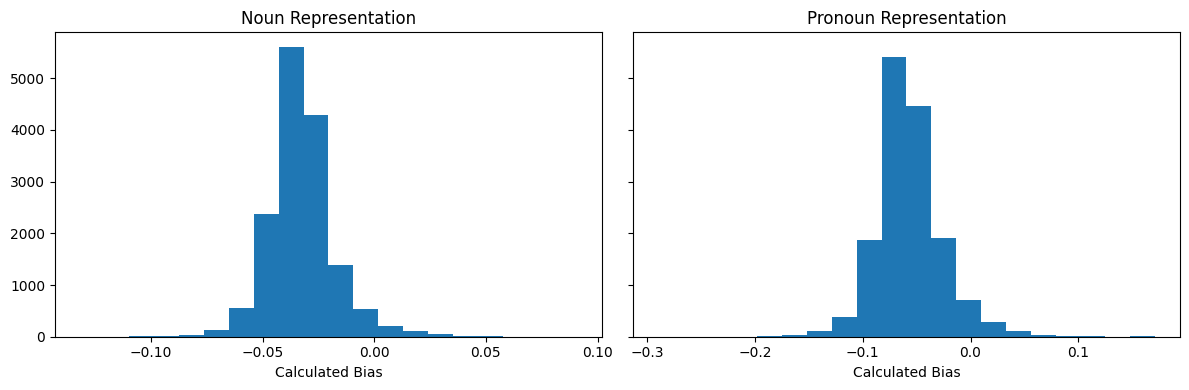

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True, tight_layout=True)

axs[0].hist(dataframe_bias_nouns['bias'], bins=20)
axs[0].set_title('Noun Representation')

axs[1].hist(dataframe_bias_pronouns['bias'], bins=20)
axs[1].set_title('Pronoun Representation')

for ax in axs:
  ax.set_xlabel('Calculated Bias')

fig.show()

There is more variance in the bias calculations based on pronouns than the bis calculations based on nouns, from roughly -0.20 to 0.10 for pronouns as compared to -0.10 to 0.05 for nouns. The combined representation is weighted toward nouns because there are more nouns in the HolisticBias dataset than there are pronouns.

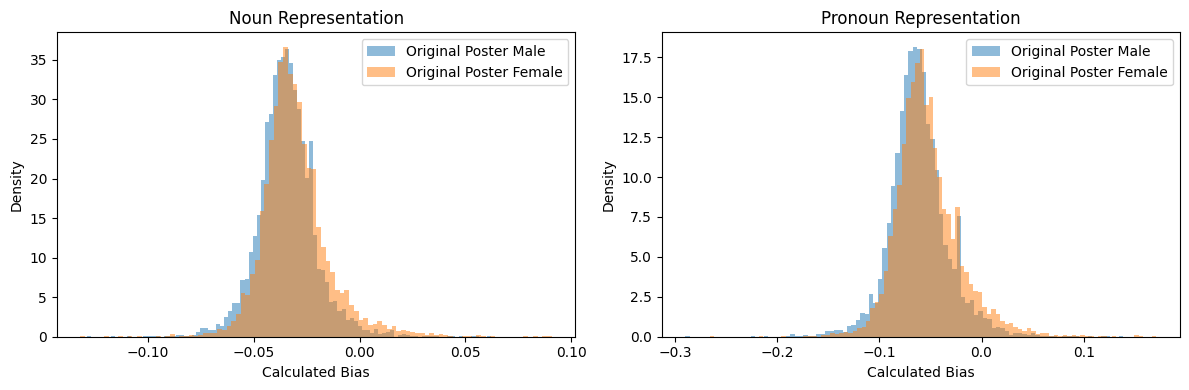

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), tight_layout=True)

axs[0].hist(dataframe_bias_nouns[dataframe_bias_nouns['op_gender'] == 'M']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Male')
axs[0].hist(dataframe_bias_nouns[dataframe_bias_nouns['op_gender'] == 'W']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Female')
axs[0].set_title('Noun Representation')

axs[1].hist(dataframe_bias_pronouns[dataframe_bias_pronouns['op_gender'] == 'M']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Male')
axs[1].hist(dataframe_bias_pronouns[dataframe_bias_pronouns['op_gender'] == 'W']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Female')
axs[1].set_title('Pronoun Representation')

for ax in axs:
  ax.set_xlabel('Calculated Bias')
  ax.set_ylabel('Density')
  ax.legend()

fig.show()

Regardless of representation, there is significant overlap in calculated bias in responses to men and women.

In [ ]:
# Calculate bias in the original post using male and female nouns
dataframe_bias_nouns_post = add_bias(dataframe_annotations, 'post_text', male_nouns, female_nouns, tokenizer, model_googlenews)

In [ ]:
# Calculate bias in the original post using male and female pronouns
dataframe_bias_pronouns_post = add_bias(dataframe_annotations, 'post_text', male_pronouns, female_pronouns, tokenizer, model_googlenews)

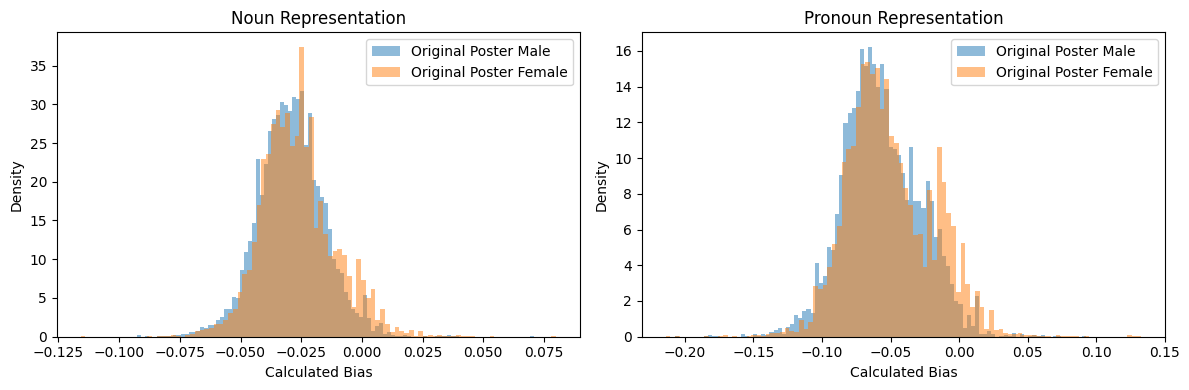

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), tight_layout=True)

axs[0].hist(dataframe_bias_nouns_post[dataframe_bias_nouns_post['op_gender'] == 'M']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Male')
axs[0].hist(dataframe_bias_nouns_post[dataframe_bias_nouns_post['op_gender'] == 'W']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Female')
axs[0].set_title('Noun Representation')

axs[1].hist(dataframe_bias_pronouns_post[dataframe_bias_pronouns_post['op_gender'] == 'M']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Male')
axs[1].hist(dataframe_bias_pronouns_post[dataframe_bias_pronouns_post['op_gender'] == 'W']['bias'], bins=100, density=True, alpha=0.5, label='Original Poster Female')
axs[1].set_title('Pronoun Representation')

for ax in axs:
  ax.set_xlabel('Calculated Bias')
  ax.set_ylabel('Density')
  ax.legend()

fig.show()

There is also significant overlap between male and female posts, suggesting that the language in posts is no more predictive of gender than the language in responses.

### Compare Males

In [ ]:
# Responses with the most male bias based on noun representation
dataframe_bias_nouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
1291,facebook_wiki,W,I love this story....so nice!,God Bless You Brother!,Positive,Irrelevant,-0.131889
1462,facebook_wiki,M,Some of my kidney stuff is on YouTube http://m...,God bless ya brother.,Positive,Content,-0.128856
8153,fitocracy,W,just joined the Fitocracy Team Fitness group!,"Yeeeah, buddy! Awesome stuff!",Positive,Content,-0.119475
7866,fitocracy,M,"Thanks for the follow, FB. Good luck with your...","Thanks, Brother. You too.",Positive,Poster,-0.115938
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.112012
5019,facebook_congress,M,"""The angel said to the women, ""Do not be afrai...",god bless cristian brother amen,Neutral,Irrelevant,-0.108247
357,facebook_wiki,W,Happy Father's Day to all the dads! Shaun Staf...,What a beautifull pic shaun brother with your ...,Positive,ContentPoster,-0.107964
741,facebook_wiki,W,Crazy lil ladies!!!!! Mis muecas :),Son mis hijas? Que bonitas.,Positive,Content,-0.107912
1831,facebook_wiki,W,Homeboy dumbfoundead fuckin killed that shit a...,Awkwafina's a Genius!!!!,Positive,Content,-0.103436
5517,facebook_congress,M,#TX23: Happy #FathersDay to my dad Bob Hurd. A...,Like Father like Son love both Mom,Positive,Content,-0.100355


In [ ]:
# Responses with the most male bias based on pronoun representation
dataframe_bias_pronouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
12563,reddit,M,How does McConnell survive if this fails?,Hopefully he doesnt.,Negative,Content,-0.290068
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.266108
10681,reddit,M,The very definition of cuckservative.,put him in a cuckservation,Neutral,Content,-0.224731
10342,reddit,W,Lol...Happy birthday dude :) next time dont go...,"If he was capable of socialising , would he sp...",Negative,Poster,-0.216120
1007,facebook_wiki,M,More adventures with Craig!,Saw him last night. He was awesome!,Positive,Content,-0.210007
2639,facebook_wiki,M,#FindCraigFriday: He once visited the signing ...,Found him! https://www.facebook.com/photo.php?...,Neutral,Content,-0.208863
10136,reddit,W,What about lion? He killed a demon and ripped ...,And then he went back to hell than back,Neutral,Content,-0.194304
13593,ted,M,"Rory Stewart gave a talk about Foreign Policy,...","If you're a veteran listen to his ""talk"" find ...",Positive,Poster,-0.188937
2302,facebook_wiki,M,Timing is everything in life and politics. If ...,And he did just that!,Neutral,Content,-0.187213
7834,fitocracy,M,"what happened to you, man. You used to be cool.",agreed. and now i'm beating him...,Negative,ContentPoster,-0.186860


In [ ]:
# Responses with the most male bias based on noun and pronoun representation
dataframe_bias_nouns_pronouns.sort_values('bias').head(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,-0.158598
1291,facebook_wiki,W,I love this story....so nice!,God Bless You Brother!,Positive,Irrelevant,-0.155535
1462,facebook_wiki,M,Some of my kidney stuff is on YouTube http://m...,God bless ya brother.,Positive,Content,-0.149149
12563,reddit,M,How does McConnell survive if this fails?,Hopefully he doesnt.,Negative,Content,-0.147669
7866,fitocracy,M,"Thanks for the follow, FB. Good luck with your...","Thanks, Brother. You too.",Positive,Poster,-0.137996
10337,reddit,M,Just shot a coat of primer then he looked inside.,Him and my uncle tore that engine down.,Positive,Content,-0.137733
8153,fitocracy,W,just joined the Fitocracy Team Fitness group!,"Yeeeah, buddy! Awesome stuff!",Positive,Content,-0.136691
357,facebook_wiki,W,Happy Father's Day to all the dads! Shaun Staf...,What a beautifull pic shaun brother with your ...,Positive,ContentPoster,-0.134988
741,facebook_wiki,W,Crazy lil ladies!!!!! Mis muecas :),Son mis hijas? Que bonitas.,Positive,Content,-0.132343
1007,facebook_wiki,M,More adventures with Craig!,Saw him last night. He was awesome!,Positive,Content,-0.130260


### Compare Females

In [ ]:
# Responses with the most female bias based on noun representation
dataframe_bias_nouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.055713
3418,facebook_congress,W,Rep Fudge Featured on WomenAchieve.com,"Congratulations, Congresswoman Fudge!",Positive,Content,0.057561
3422,facebook_congress,W,Rep Fudge Featured on WomenAchieve.com,"Congratulations, Congresswoman Fudge!",Positive,Poster,0.057561
10077,reddit,M,There are a lot on youtube. I like this channel.,She is oddly milfalicious!,Positive,Irrelevant,0.062144
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.063824
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.078805
1156,facebook_wiki,W,Good luck to our Dan Ponce Sarah Jindra and Co...,Two beautiful women!!,Positive,ContentPoster,0.082767
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.086396
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.086867
4536,facebook_congress,W,"Today, we mourn the passing of my dear friend ...",Beautiful and very talented lady/actress!,Positive,Poster,0.090833


In [ ]:
# Responses with the most female bias based on pronoun representation
dataframe_bias_pronouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
1660,facebook_wiki,M,A few months ago someone named Agnes Fred sent...,but she sings portuguese,Neutral,Content,0.124541
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.129042
347,facebook_wiki,W,10sballs.com is always in the know. Many thank...,magnifical beth.....,Mixed,Irrelevant,0.129446
1640,facebook_wiki,M,WWW.vincentmward.com,Betty white I love her,Positive,Irrelevant,0.138356
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.149659
1405,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Neutral,Irrelevant,0.149659
898,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Irrelevant,0.149659
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.152888
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.157864
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.171164


In [ ]:
# Responses with the most female bias based on noun and pronoun representation
dataframe_bias_nouns_pronouns.sort_values('bias').tail(10)

,source,op_gender,post_text,response_text,sentiment,relevance,bias
10077,reddit,M,There are a lot on youtube. I like this channel.,She is oddly milfalicious!,Positive,Irrelevant,0.059771
1405,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Neutral,Irrelevant,0.061264
633,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Content,0.061264
898,facebook_wiki,W,Thanks Star Sports India & Alan Wilkins ! Enjo...,MY BEAUTIGUL DAUGHTER MARY CAROLINE,Positive,Irrelevant,0.061264
636,facebook_wiki,W,Ammetto che pi passano gli anni meno spirito N...,Tanti Auguri Jane,Neutral,Irrelevant,0.066340
1156,facebook_wiki,W,Good luck to our Dan Ponce Sarah Jindra and Co...,Two beautiful women!!,Positive,ContentPoster,0.078916
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,0.081869
4536,facebook_congress,W,"Today, we mourn the passing of my dear friend ...",Beautiful and very talented lady/actress!,Positive,Poster,0.086848
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,0.089885
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,0.092399


### Compare Categories

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

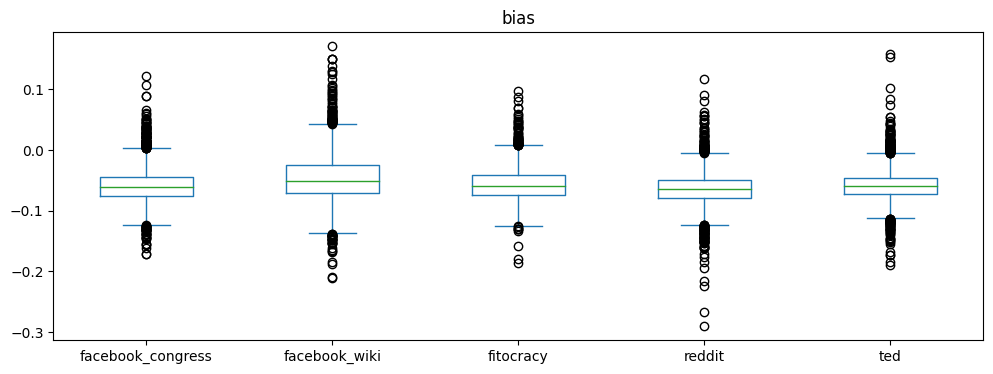

In [ ]:
dataframe_bias_pronouns.plot.box('source', figsize=(12,4))

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

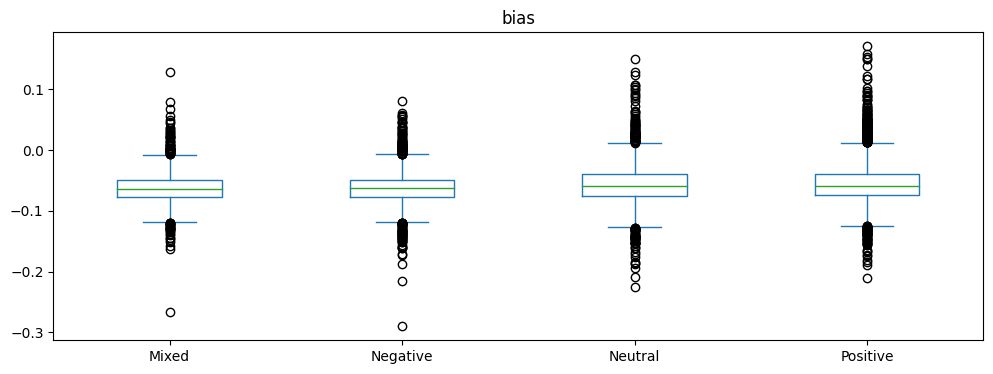

In [ ]:
dataframe_bias_pronouns.plot.box('sentiment', figsize=(12,4))

bias    Axes(0.125,0.11;0.775x0.77)
dtype: object

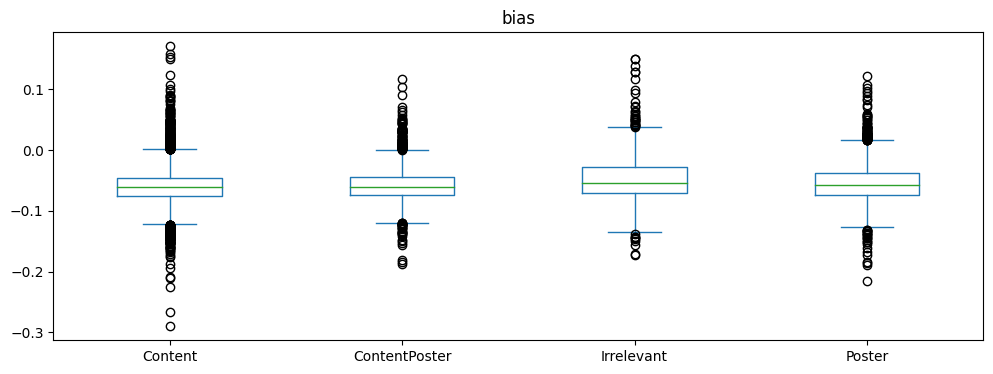

In [ ]:
dataframe_bias_pronouns.plot.box('relevance', figsize=(12,4))

In [ ]:
def split_dataframe(dataframe, text_column, gender_column, random_state=42):
    """
    Splits a dataframe into training, validation, and test sets.

    Parameters:
    - dataframe: Pandas DataFrame containing the dataset to be split.
    - text_column: The name of the column in the dataframe that contains the text data.
    - gender_column: The name of the column in the dataframe that contains the target variable.
    - random_state: An integer seed for the random number generator to ensure reproducibility. Default is 42.

    Returns:
    - X_train, y_train: Training set features and target.
    - X_val, y_val: Validation set features and target.
    - X_test, y_test: Test set features and target.
    """
    # Drop rows with missing values in the text column and copy to avoid SettingWithCopyWarning
    dataframe = dataframe.dropna(subset=[text_column]).copy()

    # Split the dataframe into training and temporary sets (70% training, 30% temp).
    X_train, X_temp, y_train, y_temp = train_test_split(
        dataframe[text_column], dataframe[gender_column],
        test_size=0.3, random_state=random_state
    )

    # Further split the temporary set into validation and test sets (50% validation, 50% test).
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5, random_state=random_state
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe(dataframe_bias_pronouns, 'response_text', 'op_gender')

## Split Data

## Singular Value Decomposition

In [ ]:
def train_vectorizer(text_data, vectorizer=CountVectorizer, tokenizer=TweetTokenizer()):
    """
    Trains a vectorizer on the provided text data and returns the vectorizer instance,
    the document-term matrix, and the feature names.

    Parameters:
    - text_data: List of text documents to be vectorized.
    - vectorizer: Vectorizer class to be used for text vectorization. Defaults to CountVectorizer.
    - tokenizer: Tokenizer class to be used for tokenizing the text documents. Defaults to TweetTokenizer.

    Returns:
    - instance: The trained vectorizer instance.
    - matrix: The document-term matrix resulting from fitting the vectorizer on `text_data`.
    - features: An array of feature names generated by the vectorizer.
    """
    # Initialize the vectorizer with specified configurations
    instance = vectorizer(
        strip_accents=None,  # Do not strip accents
        lowercase=False,  # Do not convert characters to lowercase
        tokenizer=tokenizer.tokenize,  # Use the tokenize method of the tokenizer instance
        token_pattern=None,  # Since a tokenizer is provided, token_pattern is not used
        stop_words=list(stop_words),  # Do not remove stop words
        ngram_range=(1, 1),  # Consider only single words (1-grams)
        min_df=0.05,  # Minimum document frequency for filtering terms
        max_df=0.95,  # Maximum document frequency for filtering terms
        max_features=None  # No limit on the number of features
    )

    # Fit the vectorizer on the provided text data and transform the data into a matrix
    matrix = instance.fit_transform(text_data)

    # Retrieve the feature names generated by the vectorizer
    features = instance.get_feature_names_out()

    return instance, matrix, features

In [ ]:
instance, matrix, features = train_vectorizer(X_train, vectorizer=TfidfVectorizer, tokenizer=tokenizer)

In [ ]:
def train_svd(matrix, n_components=2, random_state=42):
    """
    Trains a Truncated Singular Value Decomposition (SVD) model on the given matrix.

    Parameters:
    - matrix: The input matrix to decompose.
    - n_components: Number of components to keep.
    - random_state: Seed for the random number generator.

    Returns:
    - A tuple containing the trained SVD model, term-topic matrix, document-topic matrix,
      and array of singular values.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    model = svd.fit(np.transpose(matrix))
    term_topic_matrix = svd.transform(np.transpose(matrix))
    document_topic_matrix = svd.components_
    singular_values = svd.singular_values_

    return model, term_topic_matrix, document_topic_matrix, singular_values

In [ ]:
model, term_topic_matrix, document_topic_matrix, singular_values = train_svd(matrix)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_svd(document_topic_matrix, mask):
    """
    Plots the SVD (Singular Value Decomposition) results, separating points by gender based on a mask.

    Parameters:
    - document_topic_matrix: The document-topic matrix obtained from SVD.
    - mask: An array of gender labels ('M' for male, 'W' for female) for each document.

    Returns:
    - None
    """
    mask_male = np.where(mask == 'M', True, False)
    mask_female = np.where(mask == 'W', True, False)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, tight_layout=True)

    axs[0].scatter(document_topic_matrix[0][mask_male],
                   document_topic_matrix[1][mask_male],
                   alpha=0.1, color='C0')
    axs[0].set_title('Original Poster Male')

    axs[1].scatter(document_topic_matrix[0][mask_female],
                   document_topic_matrix[1][mask_female],
                   alpha=0.1, color='C1')
    axs[1].set_title('Original Poster Female')

    for ax in axs:
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')

    plt.show()

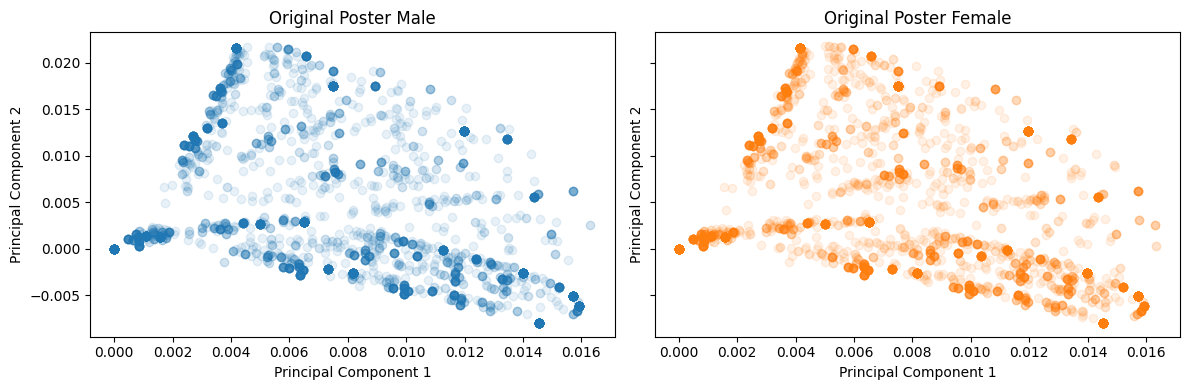

In [ ]:
plot_svd(document_topic_matrix, y_train)

## Explore Results (RtGender)

In [191]:
dataframes = {}
for name, model in tqdm(models_rtgender.items()):
  print(name)

  dataframes[name] = add_bias(dataframe_annotations, 'response_text', male_nouns, female_nouns, tokenizer, model)

  0%|          | 0/32 [00:00<?, ?it/s]

facebook_congress_stop_param_False_lemma_param_True


  3%|▎         | 1/32 [00:06<03:16,  6.35s/it]

facebook_congress_stop_param_True_lemma_param_True


  6%|▋         | 2/32 [00:11<02:47,  5.59s/it]

facebook_wiki_stop_param_False_lemma_param_False


  9%|▉         | 3/32 [00:15<02:26,  5.04s/it]

facebook_congress_stop_param_True_lemma_param_False


 12%|█▎        | 4/32 [00:22<02:34,  5.54s/it]

facebook_wiki_stop_param_True_lemma_param_False


 16%|█▌        | 5/32 [00:26<02:17,  5.09s/it]

facebook_wiki_stop_param_True_lemma_param_True


 19%|█▉        | 6/32 [00:30<02:02,  4.69s/it]

facebook_wiki_stop_param_False_lemma_param_True


 22%|██▏       | 7/32 [00:35<02:01,  4.86s/it]

facebook_congress_stop_param_False_lemma_param_False


 25%|██▌       | 8/32 [00:41<02:04,  5.18s/it]

ted_stop_param_True_lemma_param_True


 28%|██▊       | 9/32 [00:45<01:48,  4.73s/it]

ted_stop_param_True_lemma_param_False


 31%|███▏      | 10/32 [00:50<01:45,  4.82s/it]

ted_stop_param_False_lemma_param_True


 34%|███▍      | 11/32 [00:54<01:41,  4.82s/it]

ted_stop_param_False_lemma_param_False


 38%|███▊      | 12/32 [00:59<01:35,  4.75s/it]

reddit_stop_param_True_lemma_param_True


 41%|████      | 13/32 [01:05<01:34,  4.97s/it]

reddit_stop_param_True_lemma_param_False


 44%|████▍     | 14/32 [01:08<01:22,  4.58s/it]

fitocracy_stop_param_True_lemma_param_True


 47%|████▋     | 15/32 [01:12<01:12,  4.28s/it]

reddit_stop_param_False_lemma_param_False


 50%|█████     | 16/32 [01:18<01:16,  4.80s/it]

reddit_stop_param_False_lemma_param_True


 53%|█████▎    | 17/32 [01:22<01:09,  4.65s/it]

formal_stop_param_True_lemma_param_False


 56%|█████▋    | 18/32 [01:26<01:01,  4.43s/it]

informal_stop_param_True_lemma_param_False


 59%|█████▉    | 19/32 [01:31<01:01,  4.73s/it]

informal_stop_param_True_lemma_param_True


 62%|██████▎   | 20/32 [01:35<00:53,  4.46s/it]

fitocracy_stop_param_False_lemma_param_True


 66%|██████▌   | 21/32 [01:40<00:48,  4.41s/it]

formal_stop_param_False_lemma_param_False


 69%|██████▉   | 22/32 [01:46<00:49,  4.93s/it]

fitocracy_stop_param_False_lemma_param_False


 72%|███████▏  | 23/32 [01:50<00:42,  4.74s/it]

fitocracy_stop_param_True_lemma_param_False


 75%|███████▌  | 24/32 [01:54<00:35,  4.40s/it]

formal_stop_param_False_lemma_param_True


 78%|███████▊  | 25/32 [02:00<00:34,  4.92s/it]

formal_stop_param_True_lemma_param_True


 81%|████████▏ | 26/32 [02:04<00:27,  4.61s/it]

all_stop_param_False_lemma_param_False


 84%|████████▍ | 27/32 [02:08<00:23,  4.62s/it]

informal_stop_param_False_lemma_param_False


 88%|████████▊ | 28/32 [02:14<00:20,  5.08s/it]

informal_stop_param_False_lemma_param_True


 91%|█████████ | 29/32 [02:19<00:14,  4.90s/it]

all_stop_param_False_lemma_param_True


 94%|█████████▍| 30/32 [02:25<00:10,  5.23s/it]

all_stop_param_True_lemma_param_True


 97%|█████████▋| 31/32 [02:29<00:04,  4.96s/it]

all_stop_param_True_lemma_param_False


100%|██████████| 32/32 [02:33<00:00,  4.81s/it]


In [194]:
dataframes['facebook_congress_stop_param_True_lemma_param_True'].sort_values('bias')

,source,op_gender,post_text,response_text,sentiment,relevance,bias
2022,facebook_wiki,M,"""EVERYBODYY HIT HIM ON HIS GRAM RIGHT NOW AND ...",You are a rap legend why the fuck you keep pro...,Mixed,Poster,-0.045448
1502,facebook_wiki,M,Good evening... Michael Bernard Beckwith,Learning to Love Yourself and then you can hel...,Neutral,Irrelevant,-0.045134
1832,facebook_wiki,W,Into the Quarterfinals tomorrow at Hobart Inte...,Keep climbing Shelby,Positive,Content,-0.044697
6608,facebook_congress,M,Thanks to supporters in Livingston who joined ...,Nowhere near there but I hope the best for you...,Positive,Poster,-0.044296
564,facebook_wiki,W,First day in spikes! Getting some clearance wo...,i hope to see you breaking world records again.,Positive,Poster,-0.044147
...,...,...,...,...,...,...,...
3766,facebook_congress,M,Two stops today in Front Royal on the way back...,This is the Republican Party I grew up with: h...,Neutral,Irrelevant,0.041099
12605,reddit,M,If it was a joke. It would be funny.,explain Seinfeld Friends and /r/funny within t...,Negative,Content,0.041209
10483,reddit,W,"*tone: friendly, a bit amused* Seriously. That...",*tone: inquisitive* I take it youre a fan of t...,Neutral,Poster,0.041521
3998,facebook_congress,M,Thanks to everyone who called in to WAMC Vox P...,omg you wouldnt condemn the appointment of whi...,Negative,Poster,0.042210


## References

"Please annotate the following code and convert it into PEP 8." OpenAI. (2023). ChatGPT (Jan 30 version) [Large language model]. https://chat.openai.com/chat

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. PNAS, 115(16). https://doi.org/10.1073/pnas.1720347115